In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
path ='/content/drive/MyDrive/258/Assignment 6/Dataset'

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 516 files belonging to 3 classes.
Using 413 files for training.
Found 516 files belonging to 3 classes.
Using 103 files for validation.


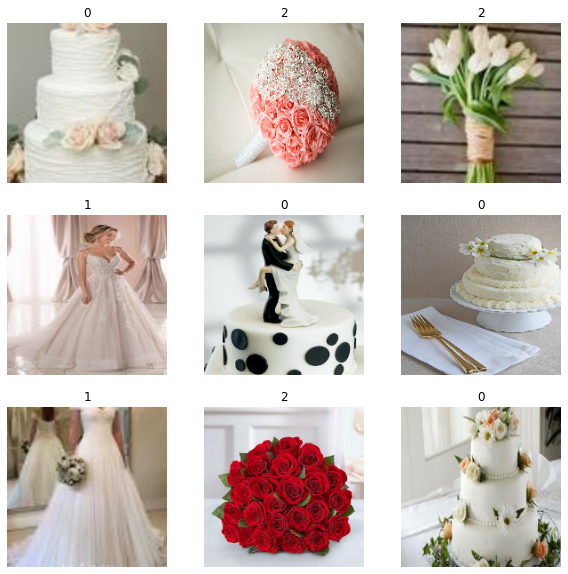

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

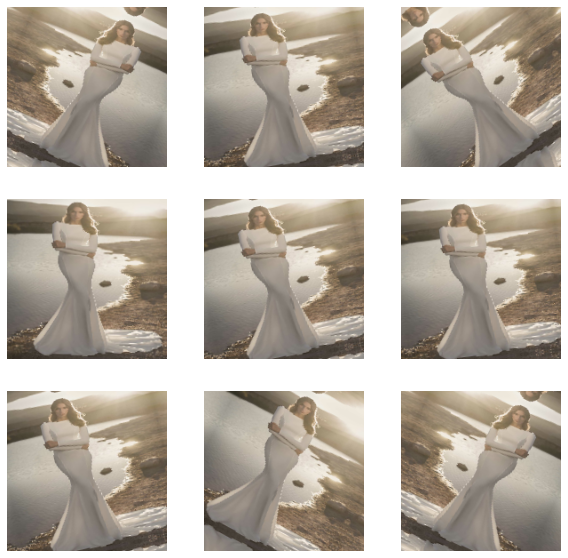

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

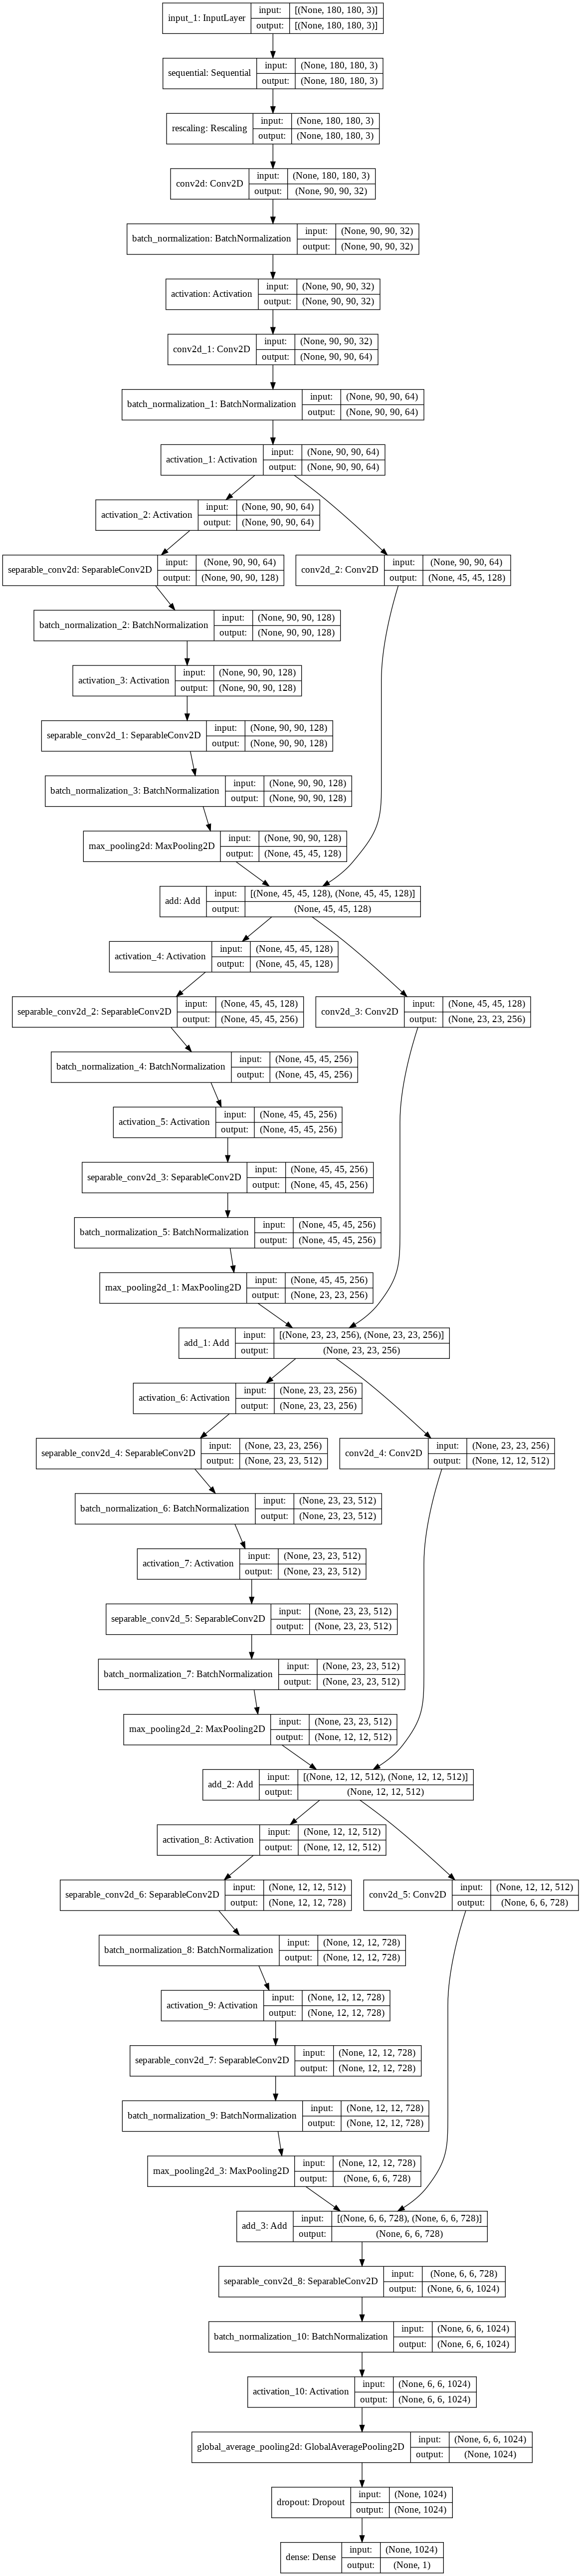

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [18]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
13/13 [==============================] - 10s 418ms/step - loss: -5.4235 - accuracy: 0.3215 - val_loss: 0.4167 - val_accuracy: 0.3301
Epoch 2/50
13/13 [==============================] - 8s 400ms/step - loss: -9.8394 - accuracy: 0.2756 - val_loss: 0.4553 - val_accuracy: 0.3301
Epoch 3/50
13/13 [==============================] - 8s 402ms/step - loss: -14.4040 - accuracy: 0.3554 - val_loss: 0.4540 - val_accuracy: 0.3301
Epoch 4/50
13/13 [==============================] - 8s 407ms/step - loss: -17.1358 - accuracy: 0.3968 - val_loss: 0.4905 - val_accuracy: 0.3301
Epoch 5/50
13/13 [==============================] - 8s 403ms/step - loss: -21.7948 - accuracy: 0.3386 - val_loss: 0.4587 - val_accuracy: 0.3301
Epoch 6/50
13/13 [==============================] - 8s 408ms/step - loss: -26.6897 - accuracy: 0.3644 - val_loss: 0.4694 - val_accuracy: 0.3301
Epoch 7/50
13/13 [==============================] - 8s 404ms/step - loss: -34.2152 - accuracy: 0.3589 - val_loss: 0.5497 - val_accuracy: 

In [11]:
#testing image path
testing_image = '/content/drive/MyDrive/258/Assignment 6/Dataset/cake/1.jpg'

In [17]:
img = keras.preprocessing.image.load_img(
    testing_image, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score_0 = predictions[0]
# score_1 = predictions[1]
# score_2 = predictions[2]

print(
    "This image is %.2f percent cake"
    % (predictions )
)

This image is 0.64 percent cake
